In [3]:
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [341]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import re
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import make_column_transformer
import joblib

In [218]:
df = pd.read_csv('./dataset.csv')

In [3]:
profile = ProfileReport(df, title='CO2 Profile Report', explorative=True)

In [9]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
profile.to_file('./profile.html')

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [219]:
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [220]:
# Find duplicates
df[df.duplicated()].shape

(1103, 12)

In [221]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [222]:
df.shape

(6282, 12)

In [223]:
# Dropping columns 
# Fuel Consumption Comb (L/100 km) is combination of city and highway
# Fuel Consumption Comb (mpg) is derived from L/100 km
# Model has high cardinality
# Dropping make

df.drop(df.columns[[0,1,-2,-3]], axis=1, inplace=True)

In [224]:
df.head()

,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km)
0,COMPACT,2.0,4,AS5,Z,9.9,6.7,196
1,COMPACT,2.4,4,M6,Z,11.2,7.7,221
2,COMPACT,1.5,4,AV7,Z,6.0,5.8,136
3,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,255
4,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,244


In [225]:
numeric_data = df._get_numeric_data()
numeric_data.head()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km)
0,2.0,4,9.9,6.7,196
1,2.4,4,11.2,7.7,221
2,1.5,4,6.0,5.8,136
3,3.5,6,12.7,9.1,255
4,3.5,6,12.1,8.7,244


In [226]:
# Cylinders is categorical
df['Cylinders'] = df['Cylinders'].astype('object') 

In [227]:
numeric_data = df._get_numeric_data()
numeric_data.head()

,Engine Size(L),Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km)
0,2.0,9.9,6.7,196
1,2.4,11.2,7.7,221
2,1.5,6.0,5.8,136
3,3.5,12.7,9.1,255
4,3.5,12.1,8.7,244


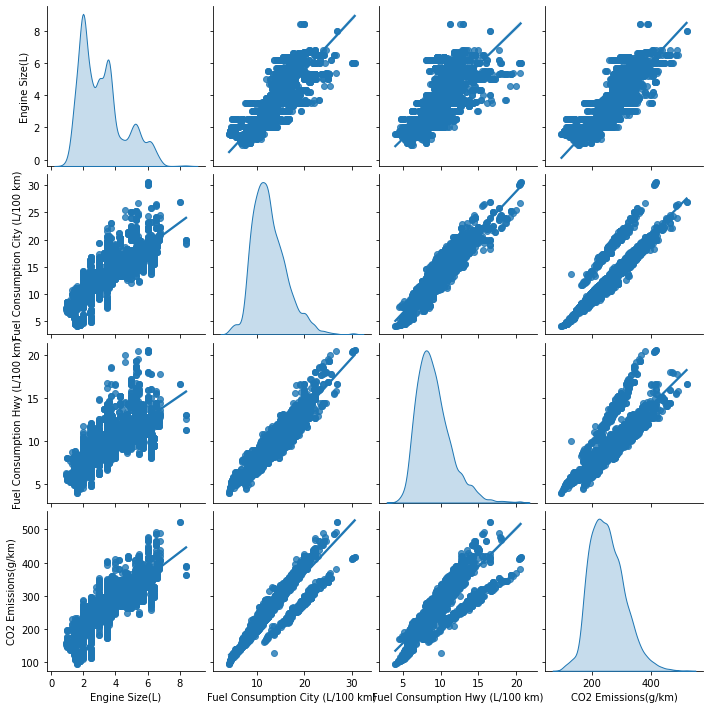

In [19]:
sns.pairplot(numeric_data, kind='reg', diag_kind='kde')

In [15]:
# Categorical variables

In [228]:
df['Vehicle Class'].value_counts()

SUV - SMALL                 1006
MID-SIZE                     983
COMPACT                      903
SUV - STANDARD               613
SUBCOMPACT                   533
FULL-SIZE                    508
PICKUP TRUCK - STANDARD      475
TWO-SEATER                   381
MINICOMPACT                  274
STATION WAGON - SMALL        214
PICKUP TRUCK - SMALL         133
VAN - PASSENGER               66
SPECIAL PURPOSE VEHICLE       65
MINIVAN                       61
STATION WAGON - MID-SIZE      45
VAN - CARGO                   22
Name: Vehicle Class, dtype: int64

In [229]:
df['Cylinders'].value_counts()

4     2749
6     2040
8     1202
12     135
3       88
10      40
5       26
16       2
Name: Cylinders, dtype: int64

In [230]:
df['Transmission'].value_counts()

AS6     1139
AS8     1056
M6       773
A6       684
AM7      383
A8       378
AS7      283
A9       263
AV       241
M5       168
AS10     151
AM6      107
AV7       92
AV6       89
M7        78
A5        78
AS9       65
A4        61
AM8       45
A7        44
AV8       34
A10       28
AS5       26
AV10       9
AM5        4
AS4        2
AM9        1
Name: Transmission, dtype: int64

```
A = Automatic
AM = Automated manual
AS = Automatic with select shift
AV = Continuously variable
M = Manual

Number represents the gears
```

Splitting this column into transmission mode and number of gears

In [231]:
df['TransmissionMode'] = df['Transmission'].apply(lambda x: re.search('[A-Z]*', x).group())

In [232]:
df['TransmissionMode'].value_counts()

AS    2722
A     1536
M     1019
AM     540
AV     465
Name: TransmissionMode, dtype: int64

In [233]:
# one of AV has no gears making it to 0 for now
df['Transmission'].replace({'AV':'AV0'}, inplace=True)

In [234]:
df['Gears'] = df['Transmission'].apply(lambda x: re.search('[0-9]+', x).group())

In [235]:
df['Gears'].value_counts()

6     2792
8     1513
7      880
9      329
5      276
0      241
10     188
4       63
Name: Gears, dtype: int64

In [236]:
df.drop(labels=['Transmission'], axis=1, inplace=True)

In [237]:
df['Fuel Type'].value_counts()

X    3039
Z    2765
E     330
D     147
N       1
Name: Fuel Type, dtype: int64

In [238]:
# Removing Natural gas fuel since there is only one entry
df.drop(df[df['Fuel Type']=='N'].index, inplace=True)

In [294]:
df.reset_index(drop=True,inplace=True)
df

,Vehicle Class,Engine Size(L),Cylinders,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km),TransmissionMode,Gears
0,COMPACT,2.0,4,Z,9.9,6.7,196,AS,5
1,COMPACT,2.4,4,Z,11.2,7.7,221,M,6
2,COMPACT,1.5,4,Z,6.0,5.8,136,AV,7
3,SUV - SMALL,3.5,6,Z,12.7,9.1,255,AS,6
4,SUV - SMALL,3.5,6,Z,12.1,8.7,244,AS,6
...,...,...,...,...,...,...,...,...,...
6276,SUV - SMALL,2.0,4,Z,10.7,7.7,219,AS,8
6277,SUV - SMALL,2.0,4,Z,11.2,8.3,232,AS,8
6278,SUV - SMALL,2.0,4,Z,11.7,8.6,240,AS,8
6279,SUV - STANDARD,2.0,4,Z,11.2,8.3,232,AS,8


In [316]:
def model1(df):
    frame = df.copy()
    y = frame['CO2 Emissions(g/km)']
    X = frame.drop(labels=['CO2 Emissions(g/km)'], axis=1)
    print(X.shape)
    X = pd.get_dummies(X, columns=['Vehicle Class','Fuel Type','TransmissionMode'])
    X['Gears'].replace({'0':np.nan}, inplace=True)
    print(X.shape)
    gearsImputer = KNNImputer()
    X = gearsImputer.fit_transform(X)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    reg = LinearRegression()
    reg.fit(X_train, y_train)
    print(reg.score(X_train, y_train), reg.score(X_test, y_test))
    print(np.sqrt(mean_squared_error(y_train, reg.predict(X_train))), np.sqrt(mean_squared_error(y_test, reg.predict(X_test))))
    return reg

reg1 = model1(df)

(6281, 8)
(6281, 30)
0.9918596984493088 0.9920897810687463
5.321537626175664 5.380734036357469


In [333]:
frame = df.copy()
y = frame['CO2 Emissions(g/km)']
X = frame.drop(labels=['CO2 Emissions(g/km)'], axis=1)
X['Cylinders'] = X['Cylinders'].astype('int')
X['Gears'] = X['Gears'].astype('int')
X['Gears'].replace({0:np.nan}, inplace=True)
X.shape
X.select_dtypes(include=['object']).columns

Index(['Vehicle Class', 'Fuel Type', 'TransmissionMode'], dtype='object')

In [349]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [344]:
oneHotEncoder = make_column_transformer(
    (OneHotEncoder(), ['Vehicle Class', 'Fuel Type', 'TransmissionMode']),
    remainder='passthrough'
)

In [352]:
pipe1 = Pipeline([
    ('encoder', oneHotEncoder),
    ('dense', DenseTransformer()),
    ('knn_imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

(0.9918649049768482, 0.9921054799730065)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe1.fit(X_train, y_train)
r2_score(y_train, pipe1.predict(X_train)), r2_score(y_test, pipe1.predict(X_test))

In [356]:
joblib.dump(pipe1, '../models/model.m5')

['../models/model.m5']

In [122]:
pipe2 = joblib.load('model.m5')

In [124]:
r2_score(y_test, pipe2.predict(X_test))

0.992682804906742

In [258]:
df2 = pd.DataFrame([X_test.iloc[0,:].to_dict()])
df2

,Vehicle Class,Engine Size(L),Cylinders,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),TransmissionMode,Gears
0,SUV - STANDARD,3.0,6,Z,15.2,12.6,AS,7


In [354]:
pipe1.predict(df2)

array([323.11139578])

In [355]:
pipe1.predict(X_test)

array([323.11089291, 291.93244299, 296.94437431, ..., 279.21216528,
       186.74874097, 195.98210158])